In [1]:
import sys
sys.path.append('/home/ahabis/1-Click_project')
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile
import os
from config import *
from model import Click_ref
from dataloader import *
from tqdm import tqdm
from beautifultable import BeautifulTable
from metrics import *
from matching import matching
from skimage.morphology import disk
import neptune.new as neptune
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.measure import label
from tqdm import trange
from tiloss import Finalloss
from glob import glob
from create_gt_grids import Gtgrid
from grids_to_clicks import Grid_to_click
import torch

/tmp/ipykernel_2018911/1978901993.py:16: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [2]:
baseline = path_stardist_modified

In [3]:
click_ref = Click_ref(7,3)
# click_ref = click_ref.load_state_dict(torch.load('weights'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# count_parameters(click_ref)

In [4]:
# filename = filenames[55]
# img_gt = tifffile.imread(os.path.join(path_gt, filename))
# img_baseline = tifffile.imread(os.path.join(path_stardist_modified, filename))
# grid_creator = Gtgrid(img_gt, img_baseline, area=0)
# grid = grid_creator.create_grid()
# click_generator = Grid_to_click(grid, filename, path_stardist_modified)
# click = click_generator.final_click()


In [5]:
# plt.imshow(img_stardist)
# plt.show()

In [6]:
click_ref = Click_ref(7,3)

# click_ref.load_state_dict(torch.load('weights'))
click_ref.eval()

Click_ref(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
  (conv_corr1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_corr2): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr3): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr4): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu): ReLU()
  )
  (conv_corr5): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU()
  )
  (conv_corr6): Conv2d_new(
    (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU()
  )
  (conv_corr7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_prob1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_prob2): Conv2d_new(
    (

fp 1
merge 0
split 1
fn 3


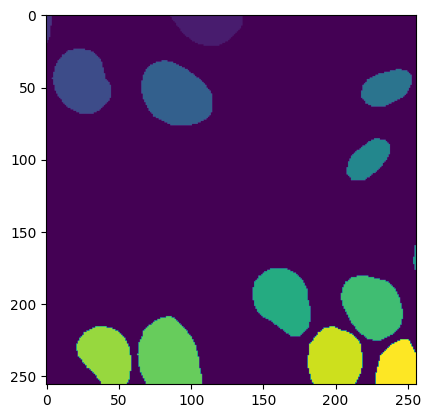

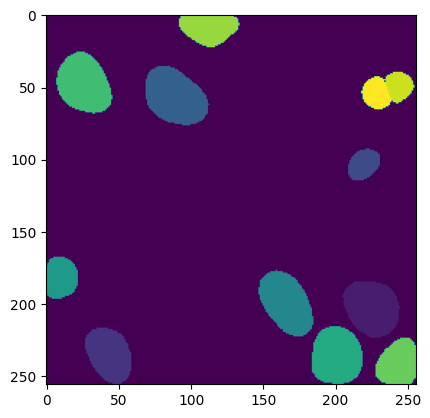

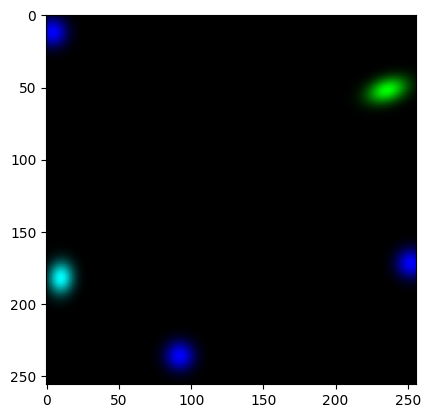

In [10]:
filename = list(dataloaders["test"].dataset.dataframe["filename"])[100]
# bin_, img_gt= model_predict(filename = filename,
#                             model=click_ref,
#                             path_baseline = path_stardist_modified,
#                             count_erase= 30)
# predict_click(
#     filename=filename,
#     model=click_ref,
#     path_baseline=path_stardist_modified,
#     count_erase=15,
#     radius=3,
# )
from metrics import n_channel_to_rgb


# filename = filenames[55]
img_gt = tifffile.imread(os.path.join(path_gt,'baseline', filename))
img_baseline = tifffile.imread(os.path.join(path_stardist_modified,'baseline', filename))
grid_creator = Gtgrid(img_gt, img_baseline, area=0)
grid = grid_creator.create_grid()
click_generator = Grid_to_click(grid, filename, path_stardist_modified)
click = click_generator.final_click()



model_predict_with_click(
    filename=filename,
    model=click_ref,
    path_baseline=path_stardist_modified,
    click=click,
    count_erase=15,
    radius=3,
)
plt.imshow(img_gt)
plt.show()
plt.imshow(img_baseline)
plt.show()
plt.imshow(n_channel_to_rgb(click))


In [8]:
dataset_test = CustomImageDataset(path_contour_baseline =path_contour_baseline,
                                   path_baseline = path_baseline,
                                   path_click_gen = path_click_baseline,
                                   path_click = path_click_baseline,
                                   path_image = path_images,
                                   path_contour_gt = path_contour_gt,
                                   path_gt = path_gt,
                                   dataframe = df_test,
                                   augmenter_bool = False)


loader_test = DataLoader(
    batch_size = parameters['batch_size'],
    dataset = dataset_test,
    num_workers = 16,
    shuffle = False)

NameError: name 'path_contour_baseline' is not defined

In [21]:
list_preds = []
list_filenames = []

with torch.no_grad():
    
    for batch in tqdm(loader_test):
        
        images    = batch[0].cuda()
        stardists    = batch[1].cuda()
        outputs    = batch[2].cuda()

        pred_outputs = click_ref(images, stardists)
        list_preds.append(pred_outputs)
        
preds = np.transpose(torch.cat(list_preds).reshape(-1,3,256,256).cpu().detach().numpy(),(0,2,3,1))

100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


In [22]:
star_P, star_R, star_F1, star_pan,star_AJI,star_DICE = [] ,[], [], [], [], []
new_P, new_R, new_F1, new_pan,new_AJI,new_DICE = [], [], [], [], [], []
t = trange(preds.shape[0])


for i in t:
        filename = list(loader_test.dataset.dataframe['filename'])[i]
        click = tifffile.imread(os.path.join(path_click_gen_baseline, filename))
 
        img = tifffile.imread(os.path.join(path_images, filename))/255.
        img_new = model_predict_batch(preds[i],
                                      count_erase= 15,
                                      radius=3)
        img_stardist =  tifffile.imread(os.path.join(path_baseline,filename)).astype(int)
        img_gt =  tifffile.imread(os.path.join(path_gt,filename)).astype(int)
        img_gt = remove_wrong_annotation(img_gt)

        precision_star, recall_star, F1_star, matched_pairs = calculate_precision_recall(img_stardist,img_gt)
        precision_seg, recall_seg, F1_seg, matched_pairs = calculate_precision_recall(img_new,img_gt)

        star_P.append(precision_star)
        star_R.append(recall_star)
        star_F1.append(F1_star)
        star_AJI.append(AJI(img_stardist,img_gt))
        star_DICE.append(DICE(img_stardist,img_gt))

        new_P.append(precision_seg)
        new_R.append(recall_seg)
        new_F1.append(F1_seg)
        new_AJI.append(AJI(img_new,img_gt))
        new_DICE.append(DICE(img_new,img_gt))
        precision_diff = np.mean(new_P) - np.mean(star_P)
        recall_diff = np.mean(new_R) - np.mean(star_R)

        t.set_description('precision diff:'+ str(np.round(precision_diff, 4)) +' || ' +'recall diff:'+ str(np.round(recall_diff, 4)))
        t.refresh()

table = BeautifulTable()

table.columns.header = ["new segmentation","stardist"]
table.rows.append([np.mean(np.array(new_P)),np.mean(np.array(star_P))])
table.rows.append([np.mean(np.array(new_R)),np.mean(np.array(star_R))])
table.rows.append([np.mean(np.array(new_F1)),np.mean(np.array(star_F1))])
table.rows.append([np.mean(np.array(new_AJI)),np.mean(np.array(star_AJI))])
table.rows.append([np.mean(np.array(new_DICE)),np.mean(np.array(star_DICE))])
table.rows.header = ["precision", "recall",'F1', "AJI", "DICE"]


precision diff:0.0711 || recall diff:0.233: 100%|██████████| 1185/1185 [09:15<00:00,  2.14it/s] 
